# Index-Guided Modes in a Strip Waveguide

In this tutorial, we'll examine different ways in which we can excite and analyze waveguides that run along arbitrary axes. First, we'll try exciting the waveguide using a simple line source. We'll notice that the source excites multiple modes and doesn't couple very efficiently. Then, we'll try coupling using an `EigenModeSource`. We'll specify a `k` vector that points along the direction of the waveguide such that it solves for the correct fundamental mode and excites the waveguide correctly.

By that same logic, we can use the mode decomposition feature with the oblique waveguids as well to extract the forward and backward propogation coefficients.

Along the way, we'll visualize the fields using animation to ensure we are simulating what we expect.

As usual, we'll first load our necesarry modules.

In [1]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Video

Using MPI version 3.1, 1 processes


Now, we'll generate our simulation domain. We'll create a waveguide that is 1 $\mu$ wide rotated by 20 degrees and with a permittivity of 12. Our simulation domain will be 2d, $14\mu m \times14\mu m$.

An oblique waveguide also leads to a breakdown in the PML. A simple workaround for mitigating the PML artifacts is to increase its length which is why the `thickness` has been doubled from 1 to 2.

We'll use a narrow band line source that expands slightly wider than the waveguide itself (2 $\mu m$) and ensure it has sufficient bandwidth (20% of the center frequency).

In [2]:
resolution = 20  # pixels/μm

cell_size = mp.Vector3(14, 14)

pml_layers = [mp.PML(thickness=2)]

# rotation angle (in degrees) of waveguide, counter clockwise (CCW) around z-axis
rot_angle = np.radians(20)

geometry = [
    mp.Block(
        center=mp.Vector3(),
        size=mp.Vector3(mp.inf, 1, mp.inf),
        e1=mp.Vector3(1).rotate(mp.Vector3(z=1), rot_angle),
        e2=mp.Vector3(y=1).rotate(mp.Vector3(z=1), rot_angle),
        material=mp.Medium(epsilon=12),
    )
]

fsrc = 0.15  # frequency of eigenmode or constant-amplitude source

sources = [
    mp.Source(
        src=mp.GaussianSource(fsrc, fwidth=0.2 * fsrc),
        center=mp.Vector3(),
        size=mp.Vector3(y=2),
        component=mp.Ez,
    )
]

sim = mp.Simulation(
    cell_size=cell_size,
    resolution=resolution,
    boundary_layers=pml_layers,
    sources=sources,
    geometry=geometry,
)

We'll plot our simulation domain to ensure we coded everything correctly:

-----------
Initializing structure...
     block, center = (0,0,0)
          size (1e+20,1,1e+20)
          axes (0.939693,0.34202,0), (-0.34202,0.939693,0), (0,0,1)


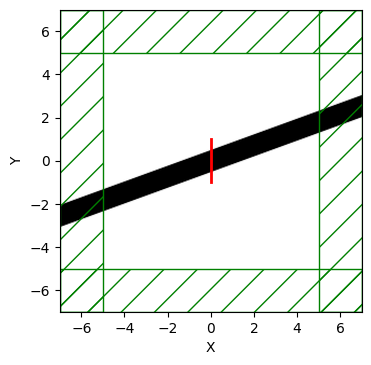

In [3]:
f = plt.figure(dpi=100)
sim.plot2D(ax=f.gca())
plt.show()

Now we'll run the simulation for 50 timesteps _after_ the source stops. We'll be sure to record the fields every 1 timestep so we can animate a video.

In [4]:
f = plt.figure(dpi=100)
animate = mp.Animate2D(mp.Ez, f=f, normalize=True)
sim.run(mp.at_every(1, animate), until_after_sources=50)
plt.close()

Meep progress: 46.95/383.3333435058594 = 12.2% done in 4.0s, 28.7s to go
Meep progress: 127.0/383.3333435058594 = 33.1% done in 8.0s, 16.2s to go
Meep progress: 210.425/383.3333435058594 = 54.9% done in 12.0s, 9.9s to go
Meep progress: 306.75/383.3333435058594 = 80.0% done in 16.0s, 4.0s to go
Normalizing field data...
run 0 finished at t = 383.35 (15334 timesteps)


Once the simulation finishes, we can output and visualize the animation within the notebook. Note that since we opted to normalize the fields, the simulation takes time to "ramp up" before any fields are visible.

In [5]:
filename = "media/oblique-source-normal.mp4"
animate.to_mp4(10, filename)
Video(filename)

Generating MP4...


As expected, the waveguide is excited and propogates in _both_ directions. The mode weakly couples until it has time to propogate along the axis, which is not ideal for some applications.

We'll now try exciting the waveguide with the `EigenModeSource`. To do so, we must supply `MPB` an initial `k` vector guess that it can use to determine the correct waveguide mode. We'll rotate the test vector, `kpoint` by the same amount that our waveguide is rotated.

Determining the parity of the source depends on the desired mode to excite and the angle of the waveguide. For even modes that propogate along the x direction (i.e. `rot_angle=0`) we can leverage both `mp.EVEN_Y` and `mp.ODD_Z`. Once we start rotating the waveguide, however, the `mp.EVEN_Y` symmetry breaks.

In [6]:
kx = 0.4  # initial guess for wavevector in x-direction of eigenmode
kpoint = mp.Vector3(kx).rotate(
    mp.Vector3(z=1), rot_angle
)  # Rotate the vector by the specified amount

bnum = 1  # band number of eigenmode

sources = [
    mp.EigenModeSource(
        src=mp.GaussianSource(fsrc, fwidth=0.2 * fsrc),
        center=mp.Vector3(),
        size=mp.Vector3(y=14),
        direction=mp.NO_DIRECTION,
        eig_kpoint=kpoint,
        eig_band=bnum,
        eig_parity=mp.EVEN_Y + mp.ODD_Z if rot_angle == 0 else mp.ODD_Z,
        eig_match_freq=True,
    )
]

sim = mp.Simulation(
    cell_size=cell_size,
    resolution=resolution,
    boundary_layers=pml_layers,
    sources=sources,
    geometry=geometry,
    symmetries=[mp.Mirror(mp.Y)] if rot_angle == 0 else [],
)

Note that in `EigenModeSource` the direction property must be set to `NO_DIRECTION` for a non-zero `eig_kpoint` which specifies the waveguide axis.

As before, we'll animate the fields to see how this approach differs.

In [7]:
f = plt.figure(dpi=100)
animate = mp.Animate2D(mp.Ez, f=f, normalize=True)
sim.run(mp.at_every(1, animate), until_after_sources=50)
plt.close()

-----------
Initializing structure...
     block, center = (0,0,0)
          size (1e+20,1,1e+20)
          axes (0.939693,0.34202,0), (-0.34202,0.939693,0), (0,0,1)
Meep progress: 51.475/383.3333435058594 = 13.4% done in 4.0s, 25.8s to go
Meep progress: 125.7/383.3333435058594 = 32.8% done in 8.0s, 16.4s to go
Meep progress: 196.625/383.3333435058594 = 51.3% done in 12.0s, 11.4s to go
Meep progress: 275.02500000000003/383.3333435058594 = 71.7% done in 16.0s, 6.3s to go
Meep progress: 351.475/383.3333435058594 = 91.7% done in 20.0s, 1.8s to go
Normalizing field data...
run 0 finished at t = 383.35 (15334 timesteps)


In [8]:
filename = "media/oblique-source-eig.mp4"
animate.to_mp4(10, filename)
Video(filename)

Generating MP4...


Once again, we need to wait for the fields to ramp up. This time, however, we see that the source only propogates in _one_ direction, and a _single_ waveguide mode is clearly visible.

Finally, we demonstrate that the total power in a waveguide with arbitrary orientation — computed using _two_ equivalent methods via `get_fluxes` and mode decomposition — can be computed by a single flux plane oriented along the $y$ direction: thanks to Poynting's theorem, the flux through any plane crossing a lossless waveguide is the same, regardless of whether the plane is oriented perpendicular to the waveguide. Furthermore, the eigenmode source is normalized in such a way as to produce the same power regardless of the waveguide orientation.

We'll perform a similar simulation as above for a waveguide oriented at 0°, 20°, and 40°. We'll measure the flux using both `get_fluxes` and `get_eigenmode_coefficients` and compare the results.

-----------
Initializing structure...
     block, center = (0,0,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Meep progress: 84.72500000000001/383.3333435058594 = 22.1% done in 4.0s, 14.1s to go
Meep progress: 180.65/383.3333435058594 = 47.1% done in 8.0s, 9.0s to go
Meep progress: 286.125/383.3333435058594 = 74.6% done in 12.0s, 4.1s to go
run 0 finished at t = 383.35 (15334 timesteps)
flux:, 1091.653061, 941.670245


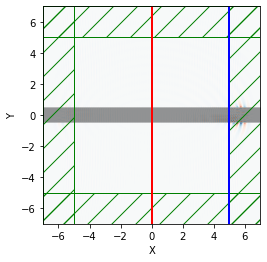

-----------
Initializing structure...
     block, center = (0,0,0)
          size (1e+20,1,1e+20)
          axes (0.939693,0.34202,0), (-0.34202,0.939693,0), (0,0,1)
Meep progress: 107.4/383.3333435058594 = 28.0% done in 4.0s, 10.3s to go
Meep progress: 214.875/383.3333435058594 = 56.1% done in 8.0s, 6.3s to go
Meep progress: 323.375/383.3333435058594 = 84.4% done in 12.0s, 2.2s to go
run 0 finished at t = 383.35 (15334 timesteps)
flux:, 1110.194293, 1111.953628


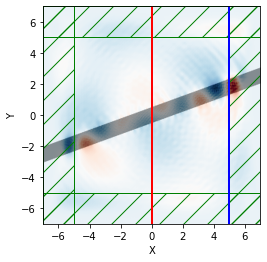

-----------
Initializing structure...
     block, center = (0,0,0)
          size (1e+20,1,1e+20)
          axes (0.766044,0.642788,0), (-0.642788,0.766044,0), (0,0,1)
Meep progress: 107.575/383.3333435058594 = 28.1% done in 4.0s, 10.3s to go
Meep progress: 207.60000000000002/383.3333435058594 = 54.2% done in 8.0s, 6.8s to go
Meep progress: 309.625/383.3333435058594 = 80.8% done in 12.0s, 2.9s to go
run 0 finished at t = 383.35 (15334 timesteps)
flux:, 1087.626286, 1041.967491


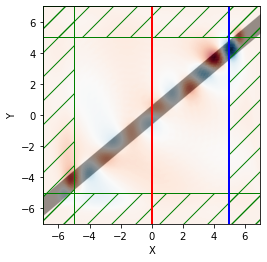

In [9]:
for rot_angle in np.radians([0, 20, 40]):

    resolution = 20

    geometry = [
        mp.Block(
            center=mp.Vector3(),
            size=mp.Vector3(mp.inf, 1, mp.inf),
            e1=mp.Vector3(1).rotate(mp.Vector3(z=1), rot_angle),
            e2=mp.Vector3(y=1).rotate(mp.Vector3(z=1), rot_angle),
            material=mp.Medium(epsilon=12),
        )
    ]

    sources = [
        mp.EigenModeSource(
            src=mp.GaussianSource(fsrc, fwidth=0.2 * fsrc),
            center=mp.Vector3(),
            size=mp.Vector3(y=14),
            direction=mp.NO_DIRECTION,
            eig_kpoint=kpoint,
            eig_band=bnum,
            eig_parity=mp.ODD_Z,
            eig_match_freq=True,
        )
    ]

    sim = mp.Simulation(
        cell_size=cell_size,
        resolution=resolution,
        boundary_layers=pml_layers,
        sources=sources,
        geometry=geometry,
    )

    tran = sim.add_flux(
        fsrc, 0, 1, mp.FluxRegion(center=mp.Vector3(x=5), size=mp.Vector3(y=14))
    )
    sim.run(until_after_sources=50)
    res = sim.get_eigenmode_coefficients(
        tran,
        [1],
        eig_parity=mp.EVEN_Y + mp.ODD_Z if rot_angle == 0 else mp.ODD_Z,
        direction=mp.NO_DIRECTION,
        kpoint_func=lambda f, n: kpoint,
    )
    print(
        "flux:, {:.6f}, {:.6f}".format(
            mp.get_fluxes(tran)[0], abs(res.alpha[0, 0, 0]) ** 2
        )
    )

    sim.plot2D(fields=mp.Ez)
    plt.show()

The flux values and measured power from `get_eigenmode_coefficients` are all close to each other well, within the discretization error. 

Note that the Poynting flux could have been normalized to unity by setting the EigenModeSource/Source object parameter amplitude=1/src.fourier_transform(fsrc) where fsrc=0.15 and src=mp.GaussianSource(fsrc,fwidth=0.2*fsrc).